In [1]:
import os
import numpy as np
import cv2
from PIL import Image
import torch
import torchvision.transforms as transforms
from collections import OrderedDict
from epillid_src.models.embedding_model import EmbeddingModel
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
model = EmbeddingModel(network='resnet50')
pt = torch.load('ePillID_data/classification_results/lr0.0001_dr0.0_lrpatience2_lrfactor0.5_resnet50_202206050046/pilltypeid_nih_sidelbls0.01_metric_5folds_3.csv.pth')
temp = OrderedDict()
for k,v in pt.items():
    if k.startswith('embedding_model.'):
        temp[k.replace('embedding_model.', '')] = v

In [3]:
model.load_state_dict(temp)

<All keys matched successfully>

In [4]:
model = model.cuda().eval()

In [5]:
def subimage(image, rect):
    theta = rect[2]-90
    center = (int(rect[0][0]),int(rect[0][1]))
    height = int(rect[1][0])
    width = int(rect[1][1])
    theta *= 3.14159 / 180 # convert to rad
    v_x = (np.cos(theta), np.sin(theta))
    v_y = (-np.sin(theta), np.cos(theta))
    s_x = center[0] - v_x[0] * ((width-1) / 2) - v_y[0] * ((height-1) / 2)
    s_y = center[1] - v_x[1] * ((width-1) / 2) - v_y[1] * ((height-1) / 2)

    mapping = np.array([[v_x[0],v_y[0], s_x],
                        [v_x[1],v_y[1], s_y]])

    cropped = cv2.warpAffine(image,mapping,(width, height),flags=cv2.WARP_INVERSE_MAP,borderMode=cv2.BORDER_REPLICATE)
    if cropped.shape[0] > cropped.shape[1]:
        cropped = cv2.rotate(cropped,cv2.ROTATE_90_COUNTERCLOCKWISE)
    cropped = cv2.resize(cropped,(224,int(224*cropped.shape[0]/cropped.shape[1])))
    zero_image = np.zeros((224,224,3),dtype=np.uint8)
    zero_image[112-cropped.shape[0]//2 : 112 +(cropped.shape[0]-cropped.shape[0]//2),:] = cropped
    return zero_image

In [6]:
def cosine_distance(a,b):
    dis = np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return dis

In [7]:
res_mean = [0.485, 0.456, 0.406]
res_std = [0.229, 0.224, 0.225]

torch_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(res_mean, res_std)
])

In [147]:
image = np.array(Image.open('nox.png'))
if image.shape[-1] == 4:
    image = cv2.cvtColor(image,cv2.COLOR_RGBA2RGB)
imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, th = cv2.threshold(imgray, 10,255,cv2.THRESH_BINARY)

# 컨튜어 찾기
contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contr = contours[0]
rect = cv2.minAreaRect(contr)

In [148]:
crop_f = subimage(image,rect)

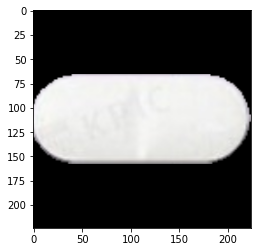

In [149]:
plt.imshow(crop_f)

In [150]:
contr = contours[1]
rect = cv2.minAreaRect(contr)
crop_b = subimage(image,rect)

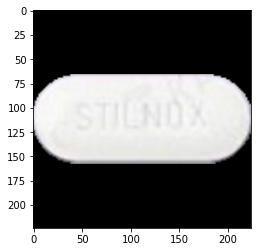

In [151]:
plt.imshow(crop_b)

In [152]:
with torch.no_grad():
    crop_ft = torch_transform(crop_f).cuda()
    crop_bt = torch_transform(crop_b).cuda()
    feat_g_ft = model(crop_ft.unsqueeze(0)).squeeze().detach().cpu().numpy()
    feat_g_bt = model(crop_bt.unsqueeze(0)).squeeze().detach().cpu().numpy()

In [153]:
feat_g_ft

array([ 0.4091675 , -0.3976912 , -0.10443185, ..., -0.3066631 ,
        0.28632423,  0.3480617 ], dtype=float32)

In [57]:
image = np.array(Image.open('image_normalized/199102092.png'))
if image.shape[-1] == 4:
    image = cv2.cvtColor(image,cv2.COLOR_RGBA2RGB)
imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, th = cv2.threshold(imgray, 10,255,cv2.THRESH_BINARY)

# 컨튜어 찾기
contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contr = contours[0]
rect = cv2.minAreaRect(contr)

In [58]:
crop_ref_f = cv2.resize(image[:256,:256],dsize=(224,224))

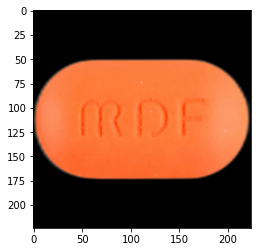

In [59]:
plt.imshow(crop_ref_f)

In [60]:
crop_ref_b = cv2.resize(image[256:,256:],dsize=(224,224))

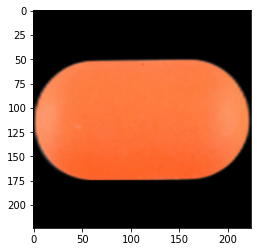

In [61]:
plt.imshow(crop_ref_b)

In [122]:
with torch.no_grad():
    crop_ft = torch_transform(crop_ref_f).cuda()
    crop_bt = torch_transform(crop_ref_b).cuda()
    feat_ft = model(crop_ft.unsqueeze(0)).squeeze().detach().cpu().numpy()
    feat_bt = model(crop_bt.unsqueeze(0)).squeeze().detach().cpu().numpy()

In [123]:
feat_bt

array([ 0.7818621 , -0.0440692 ,  0.28041464, ..., -0.3474268 ,
        0.6702159 ,  0.21763311], dtype=float32)

In [135]:
dis = cosine_distance(feat_g_ft,feat_ft)
dis

0.9265963

In [88]:
ref_imgs = 'image_normalized'
np_dir = 'features'

In [111]:
dis = 0
for f in tqdm(os.listdir(ref_imgs)):
    image = np.array(Image.open(os.path.join(ref_imgs,f)))
    if image.shape[-1] == 4:
        image = cv2.cvtColor(image,cv2.COLOR_RGBA2RGB)
    img_f = cv2.resize(image[:256,:256],(224,224))
    img_b = cv2.resize(image[256:,256:],(224,224))
    img_ft = torch_transform(img_f).cuda()
    img_bt = torch_transform(img_b).cuda()
    with torch.no_grad():
        img_f_feat = model(img_ft.unsqueeze(0)).detach().cpu().numpy()
        img_b_feat = model(img_bt.unsqueeze(0)).detach().cpu().numpy()
        img_feat = np.concatenate((img_f_feat,img_b_feat),axis=0)
        t = max(cosine_distance(feat_g_bt,img_b_feat[0])+cosine_distance(feat_g_ft,img_f_feat[0]),cosine_distance(feat_g_ft,img_b_feat[0])+cosine_distance(feat_g_bt,img_f_feat[0]))/2
        if t > dis:
            dis = t
            print(t,f)
        np.save(os.path.join(np_dir,f.split('.')[0]+'.npy'),img_feat)

  0%|          | 5/24358 [00:00<19:08, 21.20it/s]

0.2664327621459961 201905353.png
0.5003805160522461 201507777.png


  0%|          | 11/24358 [00:00<17:25, 23.28it/s]

0.6648614406585693 200501120.png


  0%|          | 65/24358 [00:02<18:44, 21.60it/s]

0.6793084144592285 200203439.png


  1%|▏         | 339/24358 [00:15<16:24, 24.39it/s]

0.7198333740234375 202100238.png


  4%|▍         | 946/24358 [00:46<18:46, 20.79it/s]

0.7568728923797607 201500372.png


 11%|█▏        | 2750/24358 [02:15<14:59, 24.03it/s]

0.76081383228302 202100229.png


 28%|██▊       | 6885/24358 [05:23<12:09, 23.95it/s]

0.767020583152771 202002987.png


 47%|████▋     | 11570/24358 [08:50<09:10, 23.23it/s]

0.7914237976074219 201903593.png


 49%|████▉     | 12007/24358 [09:08<08:16, 24.86it/s]

0.7964546084403992 200003111.png


100%|██████████| 24358/24358 [18:32<00:00, 21.89it/s]


In [154]:
l = []
for f in tqdm(os.listdir(np_dir)):
    #try:
    q_feat = np.load(os.path.join(np_dir,f))
    dis =max(cosine_distance(feat_g_bt,q_feat[0]) + cosine_distance(feat_g_ft,q_feat[1]),cosine_distance(feat_g_bt,q_feat[1])+cosine_distance(feat_g_ft,q_feat[0]))/2
    #except:
     #   print(f)
      #  continue
    l.append((dis,f.split('.')[0]))

100%|██████████| 24358/24358 [00:09<00:00, 2495.44it/s]


In [155]:
l.sort(reverse=True)
l[:40]

[(0.9329925775527954, '200808241'),
 (0.9077871441841125, '201205252'),
 (0.8929557800292969, '200410081'),
 (0.8854565620422363, '201104436'),
 (0.8781604170799255, '200002882'),
 (0.8775566816329956, '199300904'),
 (0.8701786994934082, '200410083'),
 (0.8697125911712646, '200713037'),
 (0.8666269779205322, '200700634'),
 (0.8598974347114563, '200103393'),
 (0.8539788722991943, '200600344'),
 (0.8537276983261108, '200300430'),
 (0.8484987020492554, '201207515'),
 (0.8455781936645508, '201600928'),
 (0.8452471494674683, '201003484'),
 (0.8411986827850342, '201207404'),
 (0.8315590620040894, '200410066'),
 (0.8215692043304443, '201501455'),
 (0.8211268782615662, '201905905'),
 (0.8202419877052307, '199701713'),
 (0.8188986778259277, '200402144'),
 (0.818511962890625, '201002278'),
 (0.8162450790405273, '201402067'),
 (0.8153398036956787, '200201733'),
 (0.8149865865707397, '201802989'),
 (0.8126718997955322, '201503468'),
 (0.8115792274475098, '200511067'),
 (0.8109740018844604, '201701

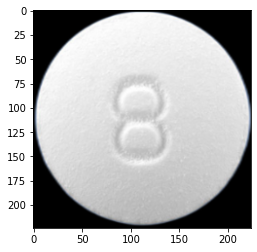

In [59]:
plt.imshow(img_b)

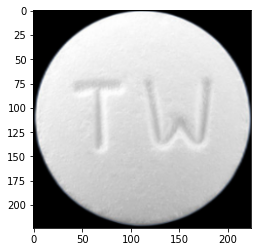

In [60]:
plt.imshow(img_f)

In [74]:
torch.save(model.state_dict(),'pill_encoder.pt')